In [13]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [566]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from geopy.geocoders import Nominatim
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [567]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

,year,importer1,importer2,flow1,flow2
0,1920,United States of America,Canada,611.85999,735.47998
1,1921,United States of America,Canada,335.44000,442.98999
2,1922,United States of America,Canada,364.01999,502.84000
3,1923,United States of America,Canada,416.00000,598.14001
4,1924,United States of America,Canada,399.14001,496.32001


Now, a first step is to reshape the data so that the flow2 column is below flow 1.

In [119]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
df.head()

,Country_A,Country_B,flow,year
0,United States of America,Canada,611.85999,1920
1,Canada,United States of America,735.47998,1920
2,United States of America,Canada,335.44000,1921
3,Canada,United States of America,442.98999,1921
4,United States of America,Canada,364.01999,1922


The flow represents the imports of Country_A from Country_B, in US millions of current dollars.

### Descriptive statistics about the evolution of the network

In [49]:
n_nodes = []
n_edges = []
for i in range(1950,2015):
    data_more_1950 = df.loc[np.where(df.year==i)[0], :]
    n_nodes.append(data_more_1950['Country_A'].nunique())
    n_edges.append(len(data_more_1950))

In [50]:
df_resume = pd.DataFrame({'year':[i for i in range(1950,2015)], 'Nb_nodes': n_nodes, 'Nb_edges':n_edges})

Text(0,0.5,'Number of nodes')

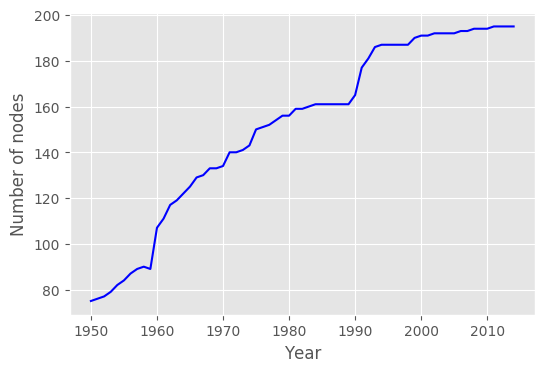

In [51]:
plt.plot(df_resume.year, df_resume.Nb_nodes, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of nodes')

The number of country in the network increases.

Text(0,0.5,'Number of edges')

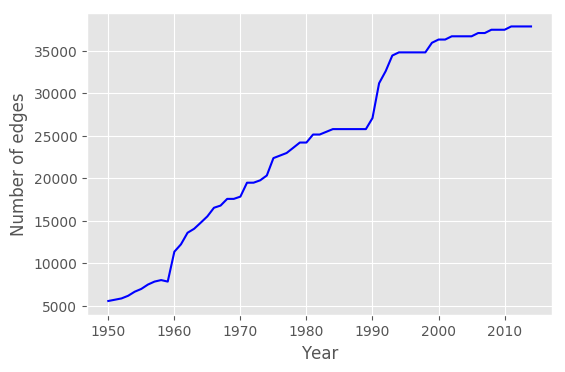

In [52]:
plt.plot(df_resume.year, df_resume.Nb_edges, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of edges')

The number of exchanges increases.

Text(0,0.5,'Number of exchanges per country')

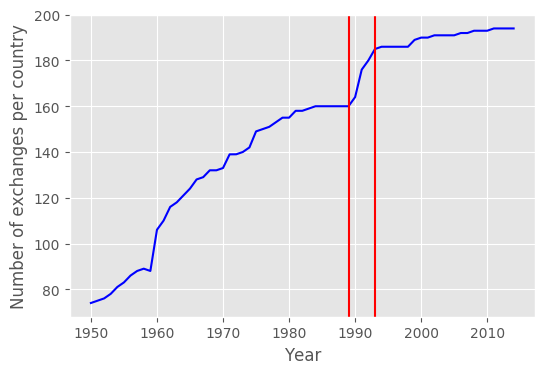

In [54]:
plt.plot(df_resume.year, df_resume.Nb_edges / df_resume.Nb_nodes, c = 'blue')
plt.axvline(x=1989, c = 'red')
plt.axvline(x=1993, c = 'red')
plt.xlabel('Year')
plt.ylabel('Number of exchanges per country')

The number of relation per country increases.

We can notice a drop in the years 1991-1993. It can come from the explosion of URSS. I will verify it.

In [55]:
lost_countries = list(set(df.loc[np.where(df.year==1989)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1993)[0],:].Country_A))
new_countries = list(set(df.loc[np.where(df.year==1993)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1989)[0],:].Country_A))

In [56]:
geolocator = Nominatim()
# Get coordinated of new countries
coordinates_new_countries = []
for i in new_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_new_countries.append((location.latitude, location.longitude))
    except:
        coordinates_new_countries.append(('lat not found', 'lon not found'))
# Get coordinated of lost countries
coordinates_lost_countries = []
for i in lost_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_lost_countries.append((location.latitude, location.longitude))
    except:
        coordinates_lost_countries.append(('lat not found', 'lon not found'))

In [57]:
df = pd.DataFrame({'Name': new_countries, 'lat': [i[0] for i in coordinates_new_countries], 'long': [i[1] for i in coordinates_new_countries]})

In [58]:
data = [ dict(
        type = 'scattergeo',
        lon = df['long'],
        lat = df['lat'],
        text = df['Name'],
        mode = 'markers',
        marker = dict(
            size = 3,
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            color='red'
        ))]

layout = dict(
        title = 'New countries between 1989 and 1993',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)

### Compute the evolution of the similarity between similarity matrices over time

In [568]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_1['key'] = data_flow_1['Country_A'] + '-' + data_flow_1['Country_B']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
data_flow_2['key'] = data_flow_2['Country_B'] + '-' + data_flow_2['Country_A']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
# Fill nan by 0
df = df.fillna(0)
# We keep years from 1950
df = df[df.year>=1950].reset_index(drop=True)

In [569]:
# This gives us the proportion of importation of Country_A from Country_B at for each yer
df['flow'] = df['flow'] / df.groupby(['year', 'Country_A'])['flow'].transform(sum) * 100
# Replace NaN by 0
df = df.fillna(0)

For each year, we compute squared symmetric average exchanges' intensity matrix

In [570]:
list_intensity_matrix = []
for i in list(df.year.unique()):
    inter_df = df[df.year==i]
    # Get squared similarity matrix
    piv_not_averaged = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
    mat_piv_not_averaged = piv_not_averaged.as_matrix()
    mat_upper_tri = (mat_piv_not_averaged * np.triu(np.ones(mat_piv_not_averaged.shape))).T
    mat_lower_tri = (mat_piv_not_averaged * np.triu(np.ones(mat_piv_not_averaged.shape)).T)
    averaged_tri = (mat_lower_tri + mat_upper_tri) / 2
    sym_matrix = averaged_tri + averaged_tri.T
    list_intensity_matrix.append(pd.DataFrame(data=sym_matrix, index=piv_not_averaged.columns, columns=piv_not_averaged.columns))

In [571]:
diff_frobenius_norm = []
for i in range(len(list_intensity_matrix)-1):
    aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0].as_matrix()
    aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1].as_matrix()
    diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))

Text(0,0.5,'Frobenius norm')

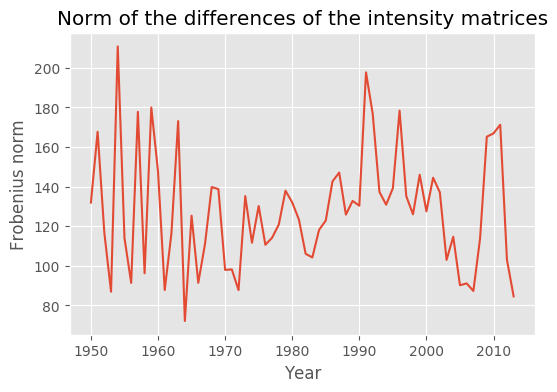

In [572]:
plt.plot(list(df.year.unique())[:-1], diff_frobenius_norm)
plt.title('Norm of the differences of the intensity matrices')
plt.xlabel('Year')
plt.ylabel('Frobenius norm')

In [573]:
# Regardons les années où la norme est supérieure à 160 afin de voir si cela correspond à des chocs
df.year.unique()[:-1][np.where(np.array(diff_frobenius_norm)>180)[0]]

array([1954, 1991])

1991 corresponds to the URSS's dislocation and 1954?

### Now we can replicate the previous analysis for each continent (to see if they are changes in the exchanges' structure in each continent)

In [574]:
continent = eval(open("continent.py").read())

In [575]:
continent_dict = {}
for i, j in enumerate(continent):
    continent_dict.update({continent[i]['name']: continent[i]['continent']})

In [576]:
countries = list(df.Country_A.unique())

In [577]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

0.8811881188118812

On a 88% des pays attachés à un continent en utilisant la méthode du dict. Je vais rajouter les autres à la main...

In [578]:
continent_dict.update({'United States of America': 'North America', 'St. Lucia':'North America','St. Vincent and the Grenadines':'North America',
 'Antigua & Barbuda':'North America', 'St. Kitts and Nevis':'North America', 'Ireland':'Europe', 'Netherlands':'Europe',
 'German Federal Republic':'Europe', 'German Democratic Republic':'Europe', 'Czechoslovakia':'Europe',
 'Yugoslavia':'Europe', 'Kosovo':'Europe', 'Sao Tome and Principe':'Africa','Gambia':'Africa', 'Ivory Coast':'Africa',
 'Congo':'Africa','Zanzibar':'Africa','South Sudan':'Africa', 'Yemen Arab Republic':'Asia',
 'Yemen People\'s Republic':'Asia', 'China':'Asia', 'Taiwan':'Asia', 'Republic of Vietnam':'Asia', 'Brunei':'Asia'})

In [579]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

1.0

Maintenant on a un mapping parfait

In [580]:
df['continent'] = list(map(continent_dict.get, df.Country_A))

L'analyse par continent peut maintenant commencer

In [581]:
continents_df = [df[df.continent==i] for i in list(df.continent.unique())]

In [613]:
list(df.continent.unique())

['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']

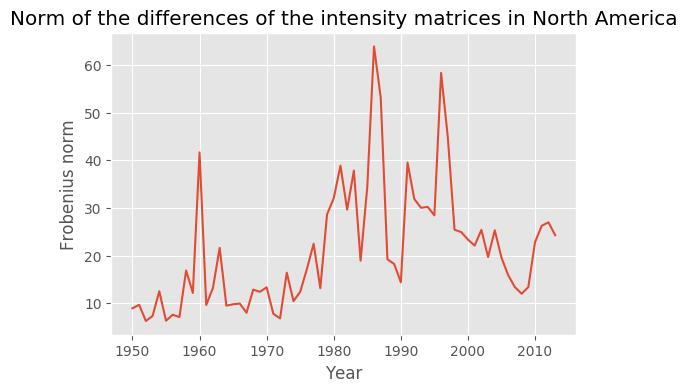

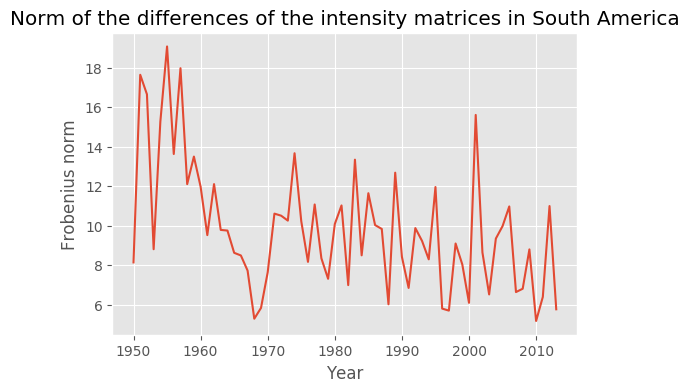

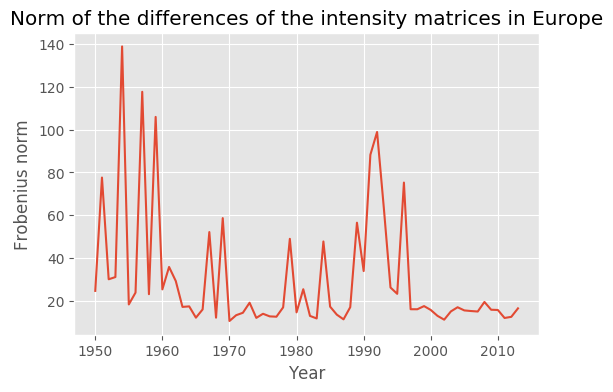

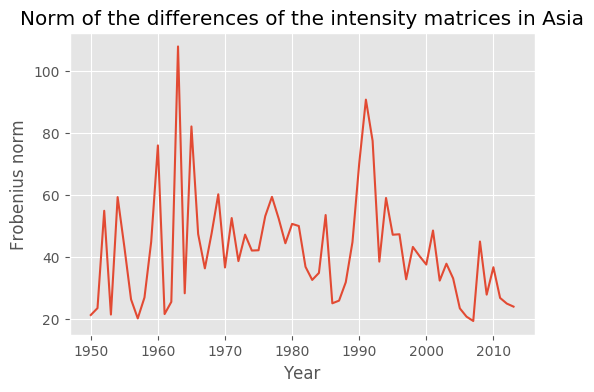

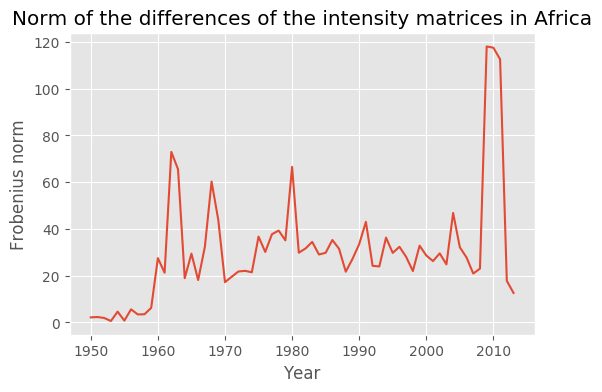

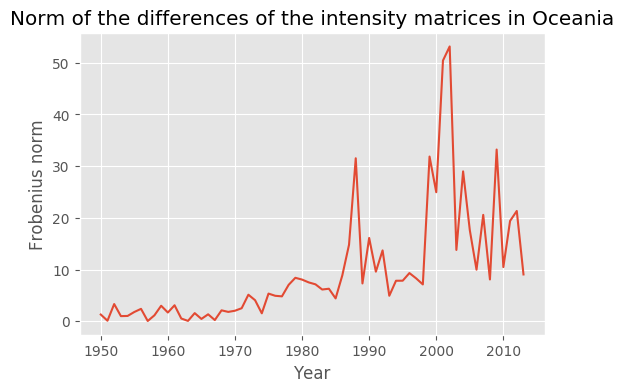

In [615]:
years = list(continents_df[0].year.unique())
for z, data in enumerate(continents_df):
    list_intensity_matrix = []
    for i in years:
        inter_df = data[data.year==i]
        # Get squared similarity matrix
        piv_not_averaged = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
        piv_not_averaged = piv_not_averaged.loc[:,piv_not_averaged.index]
        mat_piv_not_averaged = piv_not_averaged.as_matrix()
        mat_upper_tri = (mat_piv_not_averaged * np.triu(np.ones(mat_piv_not_averaged.shape))).T
        mat_lower_tri = (mat_piv_not_averaged * np.triu(np.ones(mat_piv_not_averaged.shape)).T)
        averaged_tri = (mat_lower_tri + mat_upper_tri) / 2
        sym_matrix = averaged_tri + averaged_tri.T
        list_intensity_matrix.append(pd.DataFrame(data=sym_matrix, index=piv_not_averaged.columns, columns=piv_not_averaged.columns))
    diff_frobenius_norm = []
    for i in range(len(list_intensity_matrix)-1):
        aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0].as_matrix()
        aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1].as_matrix()
        diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))
    plt.plot(years[:-1], diff_frobenius_norm)
    plt.title('Norm of the differences of the intensity matrices in ' + list(df.continent.unique())[z])
    plt.xlabel('Year')
    plt.ylabel('Frobenius norm')
    plt.show()